### Team members: Xun Zhang, Jiaying Yao, Haixin Yu, Noah Drake Duval

# Introduction 

From reverse strategy, it will generate great alpha return and as we tested, from 3-factor model, it has relatively good performance and by regression, these results are significant in the long run. Then, by segment of universe, the universed is split by 4 kinds of market capitalization and then redo the ranking of the return to form long-short(long the losers and short the winners) portfolio to test the reverse strategy. By doing this, we try to find the effect of market capitalization on the reverse strategy. In conclusion, the small market capitalization segment generates more alpha return. We want to have one more step to observe this segment. Thus, we choose short maket cap losers to make a further test of the return and can see these have relatively good information ratio and have great performance.

In [ ]:
import numpy as np
import pandas as pd
import math as math
import matplotlib.pyplot as plt
from scipy import stats
import statsmodels.formula.api as smf
import pandas_datareader as pdr
df = pd.read_csv (r'CRSP_Data_cleaned.csv',index_col='date')
df.index = pd.to_datetime(df.index.astype(str))

# Part I

In [ ]:
df_data = pd.pivot_table(df, index='date', columns='PERMNO', values='RET')
df_data.index = pd.to_datetime(df_data.index.astype(str))
df_data_forming=df_data
df_data_forming
log_df=df_data_forming
log_df=np.log(1+log_df)

In [ ]:
cs=log_df.cumsum(axis=0)
cs_eoy=cs[cs.index.month==12]
cs_eoy_lag=cs_eoy.shift(5,axis=0)
cs_eoy_lag=cs_eoy_lag.fillna(0)
Fiveret=cs_eoy-cs_eoy_lag
Fiveret
d = {}
temp=pd.DataFrame
for ind in Fiveret.index:
    temp=Fiveret[Fiveret.index==ind]
    temp=temp.dropna(axis=1)
    d[str(ind)]=temp
d2={}
#every-year ranking
for key in d:
    temp=d[key].sum(axis=0)
    temp=pd.DataFrame(temp)
    temp['port']=pd.qcut(temp[0], labels=range(10), q=10)
    temp=temp.drop([0], axis=1)
    d2[key]=temp
del d2['1960-12-30 00:00:00']
del d2['1961-12-29 00:00:00']
del d2['1962-12-31 00:00:00']
del d2['1963-12-31 00:00:00']
d3={}
for key in d2:
    temp=d2[key]
    dict_m = {}
    for m in range(10):
        dict_m['{}'.format(m)] = list(temp.loc[temp['port']==m,'port'].index)
    AA=df_data[dict_m['0']].mean(axis=1)
    AA=pd.DataFrame(AA,columns=['0'])
    X=[str(i) for i in range(1,10)]
    for m in X:
        A=df_data[dict_m[m]].mean(axis=1)
        A=pd.DataFrame(A,columns=[m])
    #turn into dataframe
        AA=pd.concat([AA,A],axis=1)
        AA=AA[AA.index>key]
        AA=AA.head(12)
    d3[key]=AA
port_returns=d3['1964-12-31 00:00:00']#Make function to do the 
for key in d3:
    temp=d3[key]
    port_returns=port_returns.append(temp)
port_returns=port_returns.iloc[12:,]

<AxesSubplot:xlabel='date'>

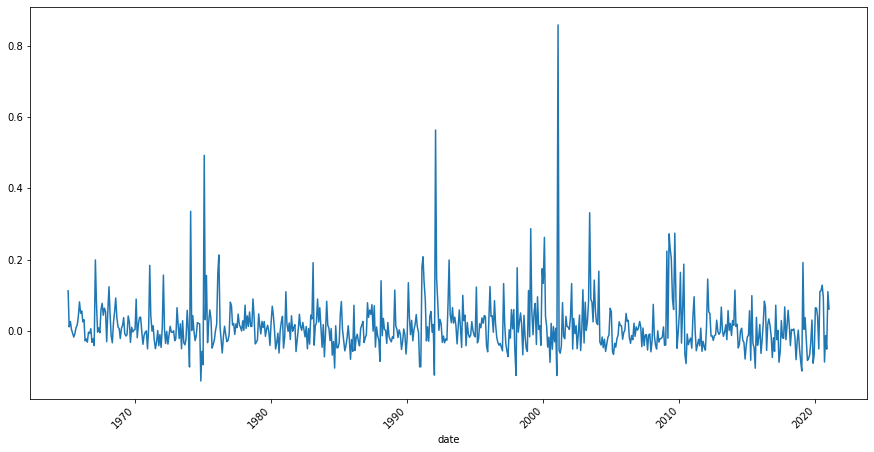

In [ ]:
#NOW - CREATE A LONG SHORT PORTFOLIO - BUY PORT 0 - (WHY?-Losers underperformance) SELL PORT 9 (WHY?-Winners Overperformance)
port_returns['LS']=port_returns['0']-port_returns['9']
port_returns["LS"].plot(figsize=(15, 8),rot=45)

### Does this dynamic disappear after a few years?
**As simple overview of the returns here, it is easy to say that this dynamic will last and had great return especially in the crisis period**

Text(0.5, 1.0, 'Long Portfolio and Short Portfolio Return')

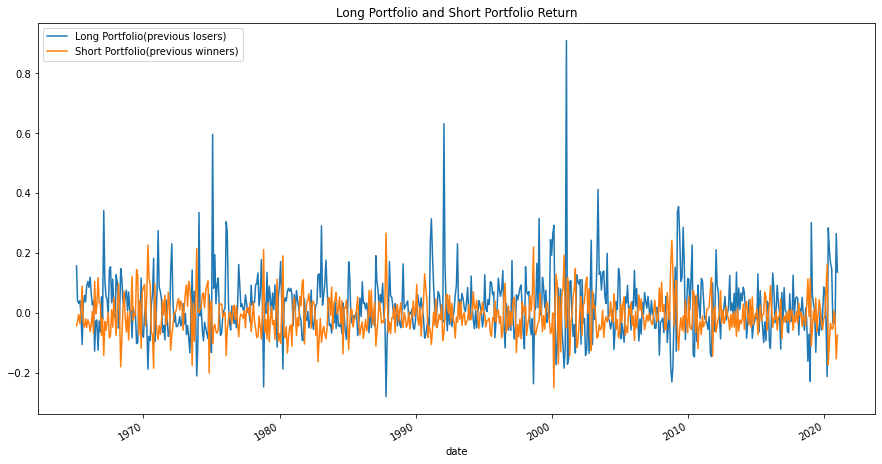

In [ ]:
port_returns['0'].plot(figsize=(15, 8))
(-1*port_returns['9']).plot()
plt.legend(['Long Portfolio(previous losers)', 'Short Portfolio(previous winners)'], loc=2)
plt.title("Long Portfolio and Short Portfolio Return")

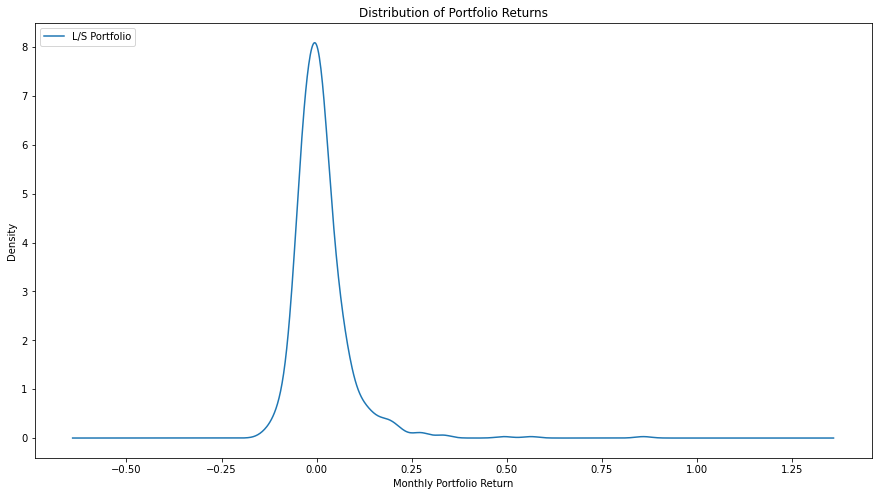

In [ ]:
# Distribution of Returns
port_returns['LS'].plot(kind='density',figsize=(15, 8) )
plt.xlabel('Monthly Portfolio Return')
plt.title('Distribution of Portfolio Returns')
plt.legend(['L/S Portfolio', 'Benchmark(S&P500)'], loc=2)
plt.show()

**As two graph shown above, the return of the portfolio has long right tail effect which means in general, it had high return.**

In [ ]:
# function that will be used
def sta_test(r):
    return r.mean()/(r.std()/(r.count()**.5))
def total_return(r):
    return (r+1).product()-1
def annual_return(r):
    years = (r.index[-1].year - r.index[0].year) + (r.index[-1].month - r.index[0].month)
    return (1 + r).prod() ** (1 / years) - 1
def annual_volatility(r):
    return np.sqrt(12) * r.std()
def sharpe_ratio(r):
    return np.sqrt(12) * r.mean() / r.std()
def plot_cumulative_return(r):
    (1 + r).cumprod().plot(figsize=(15,8))
    plt.title('Cumulative Return on $1 Investment',color="steelblue")
    plt.ylabel('Cumulative Return ($)')
    plt.axhline(1, color='k', linestyle='--')
    plt.show()
    return None
def information_ratio(r):
    return np.sqrt(12) * r.mean() / r.std()
def plot_rolling_sharpe_ratio(r, n):
    (np.sqrt(12) * r.rolling(n).mean() / r.rolling(n).std()).plot(figsize=(15,8))
    plt.title('Rolling Sharpe Ratio (' + str(n) + ' Trading Month)',color="steelblue")
    plt.ylabel('Sharpe Ratio')
    plt.axhline(sharpe_ratio(r), color='k', linestyle='--')
    plt.legend(['Rolling', 'Mean'])
    plt.show()
    return None
def drawdown(r):
    value = (1 + r).cumprod()
    return value / value.cummax() - 1
def max_drawdown(r):
    return drawdown(r).min()
def tear_sheet(r,n, plots=True):
    dic = {
      'Annual Volatility': annual_volatility(r),
      'Sharpe Ratio': sharpe_ratio(r),
      'Max Drawdown': max_drawdown(r),
      't-value': sta_test(r)
    }
    df = pd.DataFrame(data=dic.values(),columns = ['Backtest'],index=dic.keys())
    display(df)
    if plots:
        plot_cumulative_return(r)
        plot_rolling_sharpe_ratio(r,n=n)
    return None
def geo_mean(r):
    mean_=(1+total_return(r))**(1/len(r))-1
    return mean_

### 1st year

,Backtest
Annual Volatility,0.133875
Sharpe Ratio,2.330254
Max Drawdown,-0.032714
t-value,2.330254


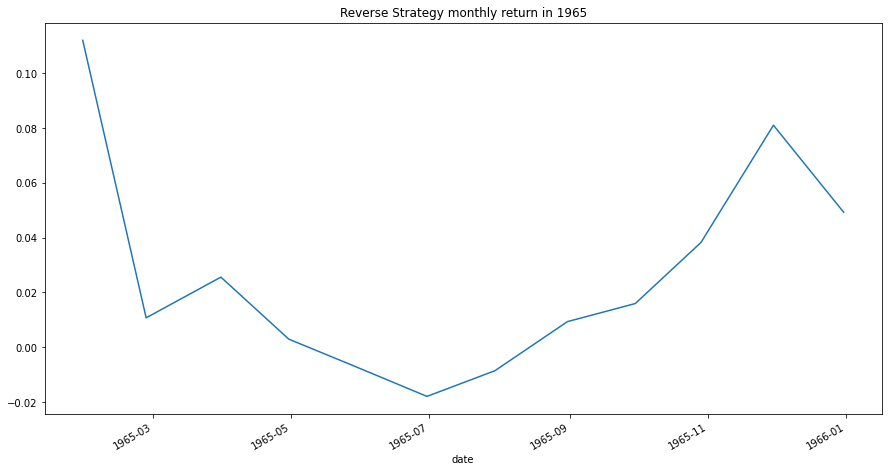

In [ ]:
LS_1_r=port_returns.loc["1965","LS"]
LS_1_r.plot(title="Reverse Strategy monthly return in 1965",figsize=(15, 8))
tear_sheet(LS_1_r,n=2,plots=False)

### Examine all the returns

,Backtest
Annual Volatility,0.261973
Sharpe Ratio,0.580229
Max Drawdown,-0.718733
t-value,4.342038


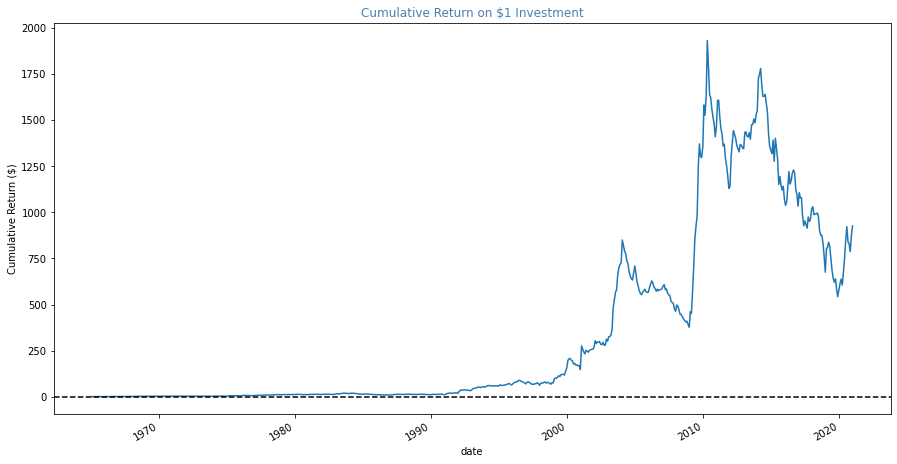

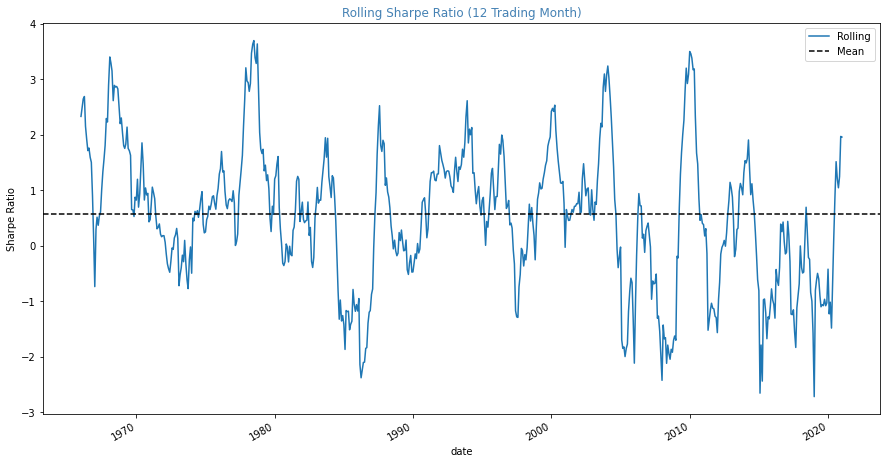

In [ ]:
tear_sheet(port_returns['LS'],n=12)

<AxesSubplot:title={'center':'Performance over sample annually'}, xlabel='date'>

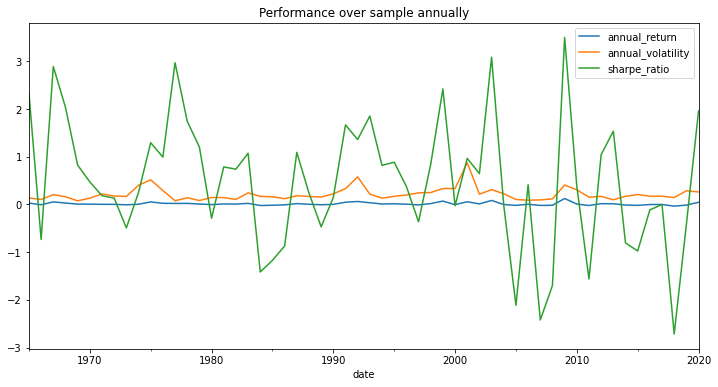

In [ ]:
Annually=port_returns['LS'].resample("Y").agg([annual_return,annual_volatility,sharpe_ratio])
Annually.plot(title="Performance over sample annually",figsize=(12,6))

In [ ]:
Annually.head()

,annual_return,annual_volatility,sharpe_ratio
date,,,
1965-12-31,0.027681,0.133875,2.330254
1966-12-31,-0.007413,0.104306,-0.734600
1967-12-31,0.052282,0.204718,2.889448
1968-12-31,0.028627,0.160168,2.033870
1969-12-31,0.005395,0.075189,0.823323


In [ ]:
port_returns=port_returns.resample("M").last()
# Data from Fame-French dataset
ff=pdr.get_data_famafrench('F-F_Research_Data_Factors', start='1960-01')
ff=pd.DataFrame(ff[0]/100)
ff.rename(columns={"Mkt-RF":"MKT"},inplace=True)
ff.index = ff.index.to_timestamp(freq='M')
#Merge
port=port_returns.merge(ff,left_index=True,right_index=True)

In [ ]:
reg1=smf.ols(formula='LS ~ MKT+SMB+HML', data=port).fit()
print(reg1.summary())
print(f"\n\nAnnualized Alpha={reg1.params[0]*12}\nβMKT={reg1.params[1]}\nβSMB={reg1.params[2]}\nβHML={reg1.params[3]}")

                            OLS Regression Results                            
Dep. Variable:                     LS   R-squared:                       0.166
Model:                            OLS   Adj. R-squared:                  0.162
Method:                 Least Squares   F-statistic:                     44.22
Date:                Thu, 05 May 2022   Prob (F-statistic):           4.46e-26
Time:                        03:17:07   Log-Likelihood:                 842.93
No. Observations:                 672   AIC:                            -1678.
Df Residuals:                     668   BIC:                            -1660.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.0089      0.003      3.293      0.0

##### They generate an alpha when analyzed against the 3 factor model. 
##### Annualized Alpha=0.1071 and its t-statistic=3.293. So alpha is significant.

In [ ]:
# Newey West se:
reg2=smf.ols(formula='LS ~ MKT+SMB+HML', data=port)
results2 = reg2.fit(cov_type='HAC', cov_kwds={'maxlags': 3},use_t=True)
results2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                     LS   R-squared:                       0.166
Model:                            OLS   Adj. R-squared:                  0.162
Method:                 Least Squares   F-statistic:                     13.43
Date:                Thu, 05 May 2022   Prob (F-statistic):           1.62e-08
Time:                        03:17:07   Log-Likelihood:                 842.93
No. Observations:                 672   AIC:                            -1678.
Df Residuals:                     668   BIC:                            -1660.
Df Model:                           3                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.0089      0.003      3.316      0.001       0.004       0.014
MKT            0.0606      0.075      0.806      0.421      -0.087       0.208
SMB            0.9119      0.159      5.719      0.000       0.599       1.225
HML            0.5810      0.193      3.011      0.003       0.202       0.960
==============================================================================
Omnibus:                      597.355   Durbin-Watson:                   1.980
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            31810.900
Skew:                           3.675   Prob(JB):                         0.00
Kurtosis:                      35.895   Cond. No.                         37.0
==============================================================================

Notes:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 3 lags and without small sample correction
"""

##### We calculate the t-statistic of alpha parameters from newey-West se to determine its significance. 
##### Alpha still be 0.0089 and its t-statistic goes up slightly to 3.316. Significant!

# Part II

In [ ]:
# Make 2 DataFrame: df_mkt for ranking, df_ret for ranking by the market cap and finding the monthly return
df["MaketCap"]=df["PRC"].abs()*df["SHROUT"]/1000
df_mkt = pd.pivot_table(df, index='date', columns='PERMNO', values='MaketCap')
df_mkt.index = pd.to_datetime(df_mkt.index.astype(str))
df_mkt=df_mkt
df_mkt.reset_index(inplace=True)
df_mkt["index"]=df_mkt["date"]
df_mkt.set_index("index",inplace=True)
df_ret = pd.pivot_table(df, index='date', columns='PERMNO', values='RET')
df_ret.index = pd.to_datetime(df_ret.index.astype(str))
df_ret=df_ret
df_ret.reset_index(inplace=True)
df_ret["index"]=df_ret["date"]
df_ret.set_index("index",inplace=True)

In [ ]:
# Double sort: first by last year of every 5 five year (the first year is 1964-12)
Ret_table=pd.DataFrame()
temp1=pd.DataFrame()
year_range=df_mkt.index.year.unique()
year_range=np.array(year_range[4::1])
for x in year_range:#from 1964,step=1
    x_str=str(x)
    x_1str=str(x+1)
    mkt=df_mkt.loc[x_str+"-12"].dropna(how='all',axis='columns')
    #print(mkt)
    mkt=mkt.mean(axis=0)
    #print(mkt)
    label=["Small","Second_Small","Second_High","High"]
    mkt_rank=pd.qcut(mkt, labels=label, q=4).to_frame()#based_on market value
    mkt_rank.columns=["MKT"]
    Month_ret={}
    for mkt in label:# every market-value to make
        try:
            a=mkt_rank[mkt_rank["MKT"]==mkt].index.to_list()
            ret_=Fiveret.loc[x_str+"-12"].reindex(columns=a).mean(axis=0)
            ret_rank_=pd.qcut(ret_, labels=range(10), q=10).to_frame()# second sort based on previous five-year return
            # This year's winners
            winner=ret_rank_[ret_rank_.iloc[:,0]==9].index.to_list()
            # This year's losers
            loser=ret_rank_[ret_rank_.iloc[:,0]==0].index.to_list()
            #Find next year's return and average returns based on winners and losers✌️
            Month_ret[f"{mkt}_Winner"]=df_ret.loc[x_1str,winner].mean(axis=1)
            Month_ret[f"{mkt}_Loser"]=df_ret.loc[x_1str,loser].mean(axis=1)
            temp=pd.DataFrame(Month_ret)   
        except:
            break
    temp1=pd.concat([temp1,temp])
temp1.index=temp1.index + pd.offsets.MonthEnd(0)
temp1=temp1.iloc[:-12]
MV=temp1.merge(ff,left_index=True,right_index=True)
MV.head()

,Small_Winner,Small_Loser,Second_Small_Winner,Second_Small_Loser,Second_High_Winner,Second_High_Loser,High_Winner,High_Loser,MKT,SMB,HML,RF
1965-01-31,0.079251,0.228237,0.043266,0.098100,0.046564,0.075722,0.052744,0.068149,0.0354,0.0270,0.0012,0.0028
1965-02-28,0.044225,0.013778,0.010584,0.048019,0.042011,0.060097,0.037736,0.038556,0.0044,0.0353,0.0011,0.0030
1965-03-31,0.024769,0.089008,0.023641,0.027497,0.010778,-0.011624,-0.011823,-0.005945,-0.0134,0.0188,0.0103,0.0036
1965-04-30,0.071625,0.028575,0.052729,0.020861,0.017426,0.036642,0.049826,0.035219,0.0311,0.0115,0.0066,0.0031
1965-05-31,0.004517,-0.031938,0.010002,-0.019717,-0.013653,-0.005460,0.012700,-0.011905,-0.0077,0.0013,-0.0161,0.0031


array([<AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>],
      dtype=object)

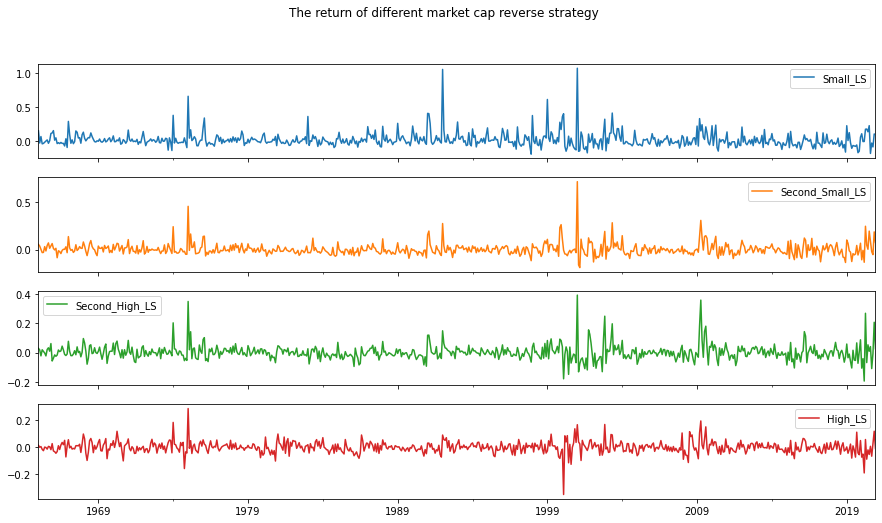

In [ ]:
MV["Small_LS"]=MV["Small_Loser"]-MV["Small_Winner"]
MV["Second_Small_LS"]=MV["Second_Small_Loser"]-MV["Second_Small_Winner"]
MV["Second_High_LS"]=MV["Second_High_Loser"]-MV["Second_High_Winner"]
MV["High_LS"]=MV["High_Loser"]-MV["High_Winner"]
MV_LS=MV.iloc[:,8:]
MV_LS.iloc[:,-4:].plot(subplots=True,figsize=(15,8),title="The return of different market cap reverse strategy")

In [ ]:
index_reg=["Annualized_Alpha","Beta_MKT","Beta_SMB","Beta_HML"]
a=MV_LS.columns[-4:]
reg=pd.DataFrame(index=index_reg)
for mm in MV_LS.columns[-4:]:
    g=smf.ols(formula=f'{mm} ~ MKT+SMB+HML', data=MV_LS).fit().params
    reg.loc["Annualized_Alpha",f"{mm}"] =g[0]*12
    reg.loc["Beta_MKT",f"{mm}"] =g[1]
    reg.loc["Beta_SMB",f"{mm}"] =g[2]
    reg.loc["Beta_HML",f"{mm}"] =g[3]

reg

,Small_LS,Second_Small_LS,Second_High_LS,High_LS
Annualized_Alpha,0.143889,-0.020736,-0.032419,-0.022696
Beta_MKT,0.372619,0.422453,0.359004,0.092936
Beta_SMB,1.204644,0.639039,0.353612,0.096399
Beta_HML,0.171703,0.382029,0.600942,0.989879


<AxesSubplot:title={'center':'Performance of reverse strategy based on different market capitalization'}>

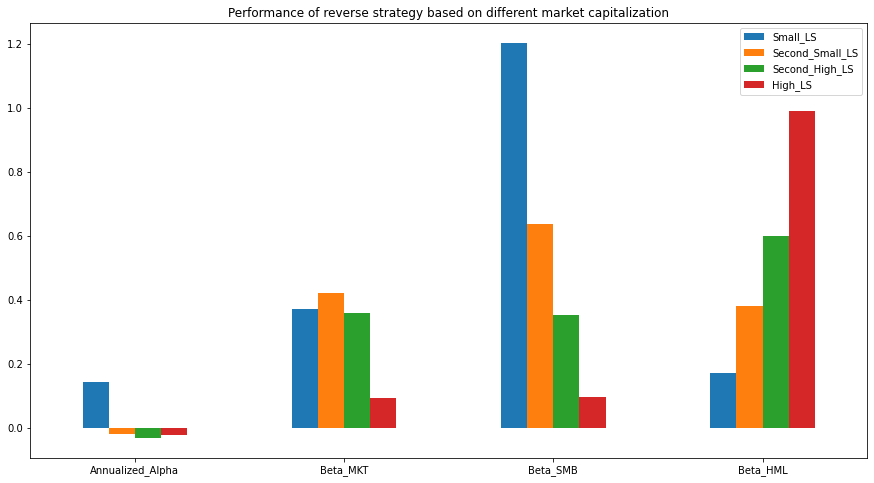

In [ ]:
reg.plot(kind="bar",figsize=(15,8),title="Performance of reverse strategy based on different market capitalization",rot=360)

##### For each quartile of market capitalization, we form long/short portfolios(Small_LS, Second_Small_LS, Second_High_LS, High_LS).
##### In total, small market capitalization reverse strategy has highest alpha(0.1439). While others all have negative alpha(-0.0207, -0.0324, -0.0227).

# Part III

For this part, as we saw before, small long-short reverse strategy has great advantage that generates more alpha. Thus, we want to see more detail of small capitalization reverse strategy. Then we choose small market losers as our sample to do this research.

In [ ]:
# Our portfolio choice: Small market capitalization losers
Port_MV=MV.loc[:,["Small_Loser","MKT"]]
Port_MV

,Small_Loser,MKT
1965-01-31,0.228237,0.0354
1965-02-28,0.013778,0.0044
1965-03-31,0.089008,-0.0134
1965-04-30,0.028575,0.0311
1965-05-31,-0.031938,-0.0077
...,...,...
2020-08-31,-0.128496,0.0763
2020-09-30,-0.018659,-0.0363
2020-10-31,-0.059097,-0.0210
2020-11-30,0.245910,0.1247


<AxesSubplot:title={'center':'Small market capitalization loser portfolio return'}>

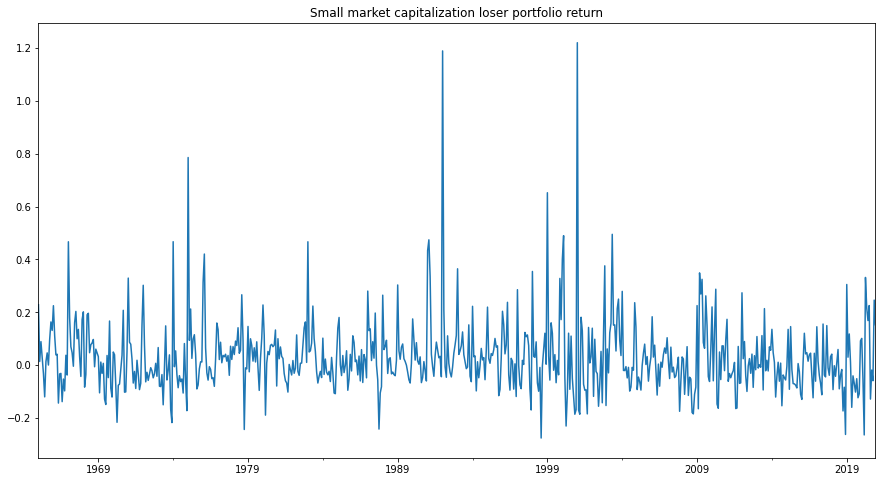

In [ ]:
Port_MV['Small_Loser'].plot(title="Small market capitalization loser portfolio return",figsize=(15,8))

<AxesSubplot:title={'center':'Small market capitalization losers\n Accumlated return of $1 investment from 1965 to 2020'}>

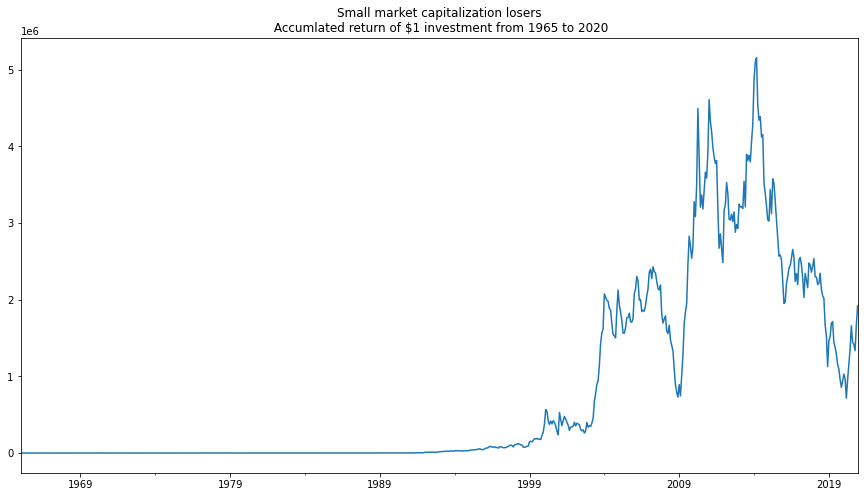

In [ ]:
Port_MV.iloc[:,0].add(1).cumprod().plot(title="Small market capitalization losers\n Accumlated return of $1 investment from 1965 to 2020",figsize=(15,8))

In [ ]:
Annually2=Port_MV.iloc[:,0].resample("Y").agg([annual_return])
Annually2.head()

,annual_return
1965-12-31,0.055961
1966-12-31,-0.012758
1967-12-31,0.131609
1968-12-31,0.075870
1969-12-31,-0.041849


In [ ]:
#standard deviation and information ratio
sd=Annually2.std()
annual_sd=np.sqrt(12)*sd[0]
print(f"Standard deviation of whole period is {sd[0]}")
print(f"Annualized Standard deviation of whole period is {annual_sd}")
infor_mation=geo_mean(Annually2)/annual_sd
infor_mation
print(f"Information ratio of whole period is {infor_mation[0]}")

Standard deviation of whole period is 0.049751984424299796
Annualized Standard deviation of whole period is 0.17234592960052533
Information ratio of whole period is 0.13788125310337018


**The information ratio based on the geometric average annual returns and annualized standard deviation here is around 0.14 which is near to 0.15 which means it has good performance.**

### Examine the returns by decade: rolling

<AxesSubplot:title={'center':'Rolling every 10-year from diffirent month'}>

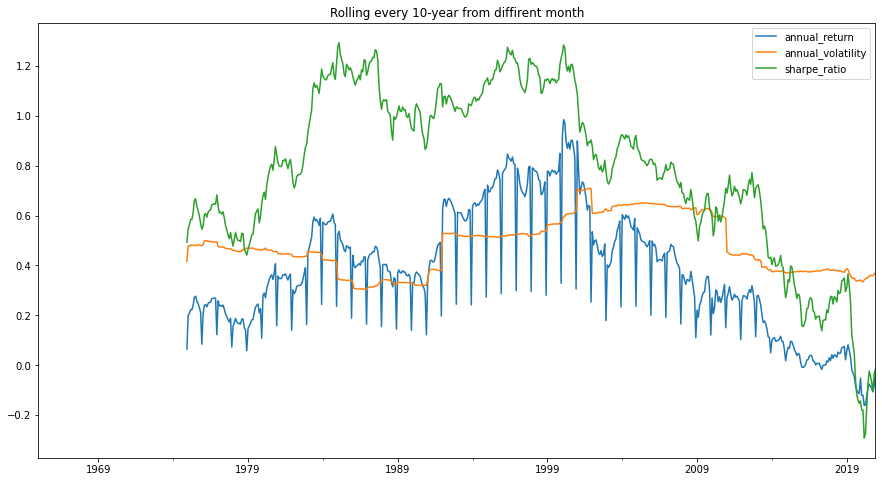

In [ ]:
rol_port=Port_MV.iloc[:,0].rolling(12*10).agg([annual_return,annual_volatility,sharpe_ratio])
rol_port.plot(figsize=(15,8),title="Rolling every 10-year from diffirent month")

As we can see here, by rolling every 10 year, the return has relatively high annual volatility and has good performance in returns. Here, there is high sharpe ratio in general.

### CAPM model

In [ ]:
h=smf.ols(formula=f'Small_Loser ~ MKT', data=Port_MV).fit()
print(h.summary())
h=h.params
print(f"\n\nAnnualized alpha={h[0]*12}\n\nBeta={h[1]}")

**As we can see here, in CAPM model, t-stat of intercept and market premium is high and p-value is 0. So annualized alpha=0.2598, beta=1.452 are both significant.**

In [ ]:
# Newey West se:
reg4=smf.ols(formula=f'Small_Loser ~ MKT', data=Port_MV)
results4 = reg4.fit(cov_type='HAC', cov_kwds={'maxlags': 3},use_t=True)
results4.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            Small_Loser   R-squared:                       0.225
Model:                            OLS   Adj. R-squared:                  0.224
Method:                 Least Squares   F-statistic:                     177.7
Date:                Thu, 05 May 2022   Prob (F-statistic):           3.96e-36
Time:                        03:52:03   Log-Likelihood:                 462.12
No. Observations:                 672   AIC:                            -920.2
Df Residuals:                     670   BIC:                            -911.2
Df Model:                           1                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.0217      0.005      4.598      0.000       0.012       0.031
MKT            1.4521      0.109     13.331      0.000       1.238       1.666
==============================================================================
Omnibus:                      566.737   Durbin-Watson:                   1.929
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            20387.210
Skew:                           3.528   Prob(JB):                         0.00
Kurtosis:                      29.045   Cond. No.                         22.1
==============================================================================

Notes:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 3 lags and without small sample correction
"""

# Conclusion
Reverse strategt by backtesting can generate great alpha return especially in small market capitalization segment and these results by regression are significant.